<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Lab: Fun with Neural Nets

---

Below is a procedure for building a neural network to recognize handwritten digits.  The data is from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data), and you will submit your results to Kaggle to test how well you did!

1. Load the training data (`train.csv`) from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
2. Setup X and y (feature matrix and target vector)
3. Split X and y into train and test subsets.
4. Preprocess your data

   - When dealing with image data, you need to normalize your `X` by dividing each value by the max value of a pixel (255).
   - Since this is a multiclass classification problem, keras needs `y` to be a one-hot encoded matrix
   
5. Create your network.
   - Remember that for multi-class classification you need a softmax activation function on the output layer.
   - You may want to consider using regularization or dropout to improve performance.
   
6. Train your network.
7. If you are unhappy with your model performance, try to tighten up your model by adding hidden layers, adding hidden layer units, chaining the activation functions on the hidden layers, etc.
8. Load in [Kaggle's](https://www.kaggle.com/c/digit-recognizer/data) `test.csv`
9. Create your predictions (these should be numbers in the range 0-9).
10. Save your predictions and submit them to Kaggle.

---

For this lab, you should complete the above sequence of steps for **_at least_** two of the four "configurations":

1. Using a `tensorflow` network (we did _not_ cover this in class!)
2. Using a `keras` convolutional network
3. Using a `keras` network with regularization
4. Using a `tensorflow` convolutional network (we did _not_ cover this in class!)

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, \
Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(42000, 785)

In [5]:
df.dtypes

label       int64
pixel0      int64
pixel1      int64
pixel2      int64
pixel3      int64
            ...  
pixel779    int64
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
Length: 785, dtype: object

In [6]:
df.max()[df.max()!=0].sort_values(ascending=False)

pixel399    255
pixel549    255
pixel486    255
pixel487    255
pixel488    255
           ... 
pixel32      16
pixel617     10
pixel15       9
label         9
pixel169      4
Length: 709, dtype: int64

In [7]:
X = df.drop(columns=['label']).values
y = df['label'].values

In [8]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [9]:
X = X.astype('float32')
X /= 255.0

In [10]:
# Check max/min
print(f"Max: {X.max()}")
print(f"Min: {X.min()}")

Max: 1.0
Min: 0.0


In [11]:
X.shape

(42000, 784)

In [12]:
# Reshape data using in CNNs
X = np.reshape(X,(42000, 28, 28))
X.shape

(42000, 28, 28)

In [13]:
# Split the data
# X before y, train before test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42)

In [14]:
# Reshape each image to be 28 x 28 x 1
# The 1 corresponds to the one black/white value
# If we had a color image, we would likely use 3 for RGB
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [15]:
X_train.shape, X_test.shape

((31500, 28, 28, 1), (10500, 28, 28, 1))

In [16]:
# Change y_train
y_train = utils.to_categorical(y_train,10)
y_test = utils.to_categorical(y_test,10)

In [17]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

### Convolutional Network

In [18]:
# 1. structure/topology
model = Sequential()
model.add(Conv2D(filters=16, # number of filter
                 kernel_size=(3,3), # height/width of filter
                 activation='relu', 
                 input_shape=(28,28,1))) # shape of input
# Add a pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [19]:
def compile_fit(model, optimizer='adam',batch_size=128,n_epochs=10,verbose=1):
    """Compile and fit Neural network"""
    # 2. Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # 3. Fit model on training data
    history = model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        epochs=n_epochs,
                        verbose=verbose)
    return model, history

In [20]:
# Compile and fit the CNN model
model, history = compile_fit(model)

Epoch 1/10
247/247 [==============================] - 9s 33ms/step - loss: 0.3267 - accuracy: 0.9043 - val_loss: 0.1188 - val_accuracy: 0.9657
Epoch 2/10
247/247 [==============================] - 10s 40ms/step - loss: 0.0900 - accuracy: 0.9726 - val_loss: 0.0776 - val_accuracy: 0.9776
Epoch 3/10
247/247 [==============================] - 10s 42ms/step - loss: 0.0591 - accuracy: 0.9820 - val_loss: 0.0793 - val_accuracy: 0.9751
Epoch 4/10
247/247 [==============================] - 10s 41ms/step - loss: 0.0477 - accuracy: 0.9856 - val_loss: 0.0546 - val_accuracy: 0.9838
Epoch 5/10
247/247 [==============================] - 8s 31ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.0557 - val_accuracy: 0.9836
Epoch 6/10
247/247 [==============================] - 8s 31ms/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0448 - val_accuracy: 0.9866
Epoch 7/10
247/247 [==============================] - 8s 31ms/step - loss: 0.0228 - accuracy: 0.9922 - val_loss: 0.0482 - val_accuracy: 0.9

In [21]:
def loss_graph(history):
    """Display training and testing loss by epoch"""
    
    # Check out our train loss and test loss over epochs
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_labels = history.epoch

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='royalblue')
    plt.plot(test_loss, label='Testing Loss', color='salmon')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Categorical Crossentropy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels) # (ticks, labels)

    plt.legend(fontsize=18);

In [22]:
def accuracy_graph(history):
    """Display training and testing accuracy by epoch"""
    # Check out our train loss and test loss over epochs
    train_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    epoch_labels = history.epoch

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_acc, label='Training Accuracy', color='royalblue')
    plt.plot(test_acc, label='Testing Accuracy', color='salmon')

    # Set title
    plt.title('Training and Testing Accuracy by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels) # (ticks, labels)

    plt.legend(fontsize=18);

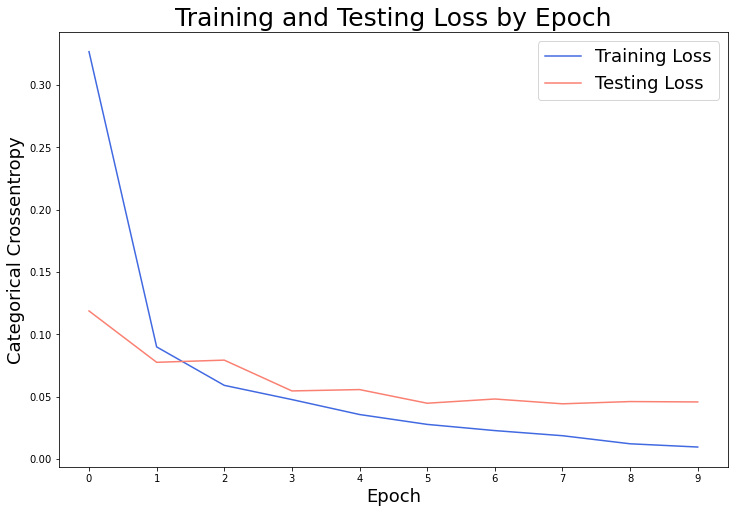

In [23]:
# Training and testing loss
loss_graph(history)

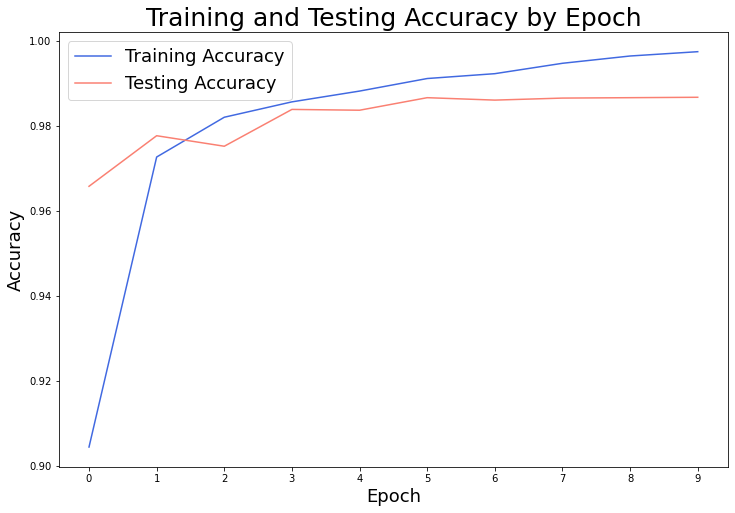

In [24]:
# Training and testing accuracy
accuracy_graph(history)

### Network with Regularization

In [25]:
# 1. structure/topology
model1 = Sequential()
model1.add(Conv2D(filters=16, # number of filter
                 kernel_size=(3,3), # height/width of filter
                 activation='relu', 
                 input_shape=(28,28,1))) # shape of input
# Add a pooling layer
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(32,
                 kernel_size=(3,3),
                 activation='relu'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu',
                kernel_regularizer=l2(0.001)))
model1.add(Dense(10, activation='softmax'))

In [26]:
# Compile and Fit
model1, history1 = compile_fit(model1)

Epoch 1/10
247/247 [==============================] - 9s 32ms/step - loss: 0.4490 - accuracy: 0.8972 - val_loss: 0.2120 - val_accuracy: 0.9635
Epoch 2/10
247/247 [==============================] - 9s 35ms/step - loss: 0.1747 - accuracy: 0.9698 - val_loss: 0.1606 - val_accuracy: 0.9718
Epoch 3/10
247/247 [==============================] - 8s 31ms/step - loss: 0.1322 - accuracy: 0.9775 - val_loss: 0.1249 - val_accuracy: 0.9782
Epoch 4/10
247/247 [==============================] - 8s 31ms/step - loss: 0.1142 - accuracy: 0.9798 - val_loss: 0.1051 - val_accuracy: 0.9826
Epoch 5/10
247/247 [==============================] - 8s 31ms/step - loss: 0.0971 - accuracy: 0.9839 - val_loss: 0.0989 - val_accuracy: 0.9820
Epoch 6/10
247/247 [==============================] - 8s 33ms/step - loss: 0.0956 - accuracy: 0.9840 - val_loss: 0.0903 - val_accuracy: 0.9852
Epoch 7/10
247/247 [==============================] - 9s 35ms/step - loss: 0.0834 - accuracy: 0.9857 - val_loss: 0.0978 - val_accuracy: 0.9813

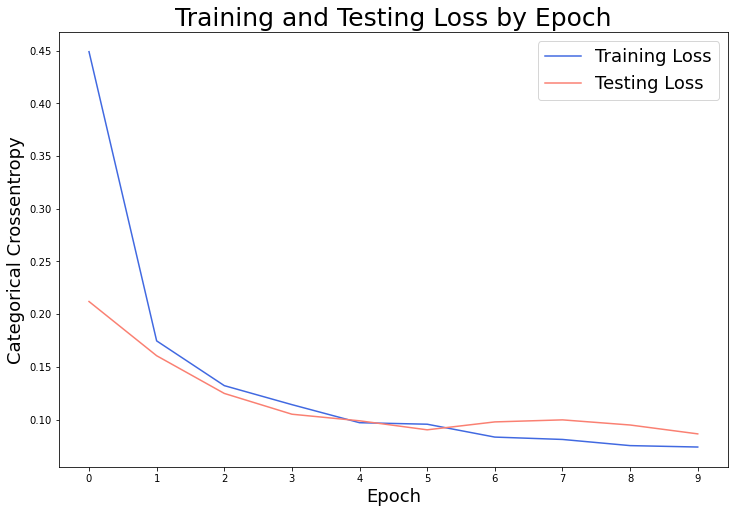

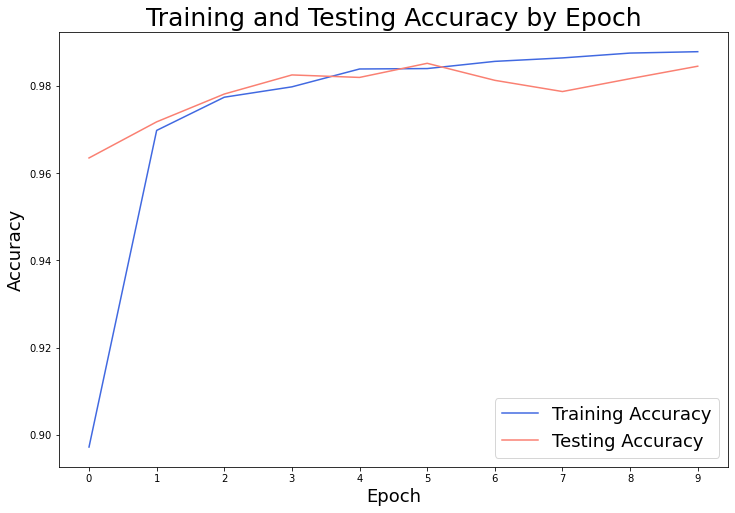

In [27]:
# Training and testing loss
loss_graph(history1)

# Training and testing accuracy
accuracy_graph(history1)

### Another Neural Networks

In [46]:
# 1. structure/topology
model2 = Sequential()
model2.add(Conv2D(filters=16, # number of filter
                 kernel_size=(3,3), # height/width of filter
                 activation='relu', 
                 input_shape=(28,28,1))) # shape of input
# Add a pooling layer
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(32,
                 kernel_size=(3,3),
                 activation='relu'))
model2.add(Flatten())
model2.add(Dense(32, activation='relu',
                kernel_regularizer=l2(0.001)))
model2.add(Dense(10, activation='softmax'))

In [47]:
# Compile and Fit
model2, history2 = compile_fit(model2,n_epochs=20)

Epoch 1/20
247/247 [==============================] - 7s 29ms/step - loss: 0.4364 - accuracy: 0.8924 - val_loss: 0.2102 - val_accuracy: 0.9554
Epoch 2/20
247/247 [==============================] - 7s 27ms/step - loss: 0.1686 - accuracy: 0.9655 - val_loss: 0.1625 - val_accuracy: 0.9694
Epoch 3/20
247/247 [==============================] - 7s 27ms/step - loss: 0.1327 - accuracy: 0.9752 - val_loss: 0.1388 - val_accuracy: 0.9726
Epoch 4/20
247/247 [==============================] - 7s 26ms/step - loss: 0.1149 - accuracy: 0.9787 - val_loss: 0.1225 - val_accuracy: 0.9768
Epoch 5/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0999 - accuracy: 0.9819 - val_loss: 0.1011 - val_accuracy: 0.9816
Epoch 6/20
247/247 [==============================] - 7s 27ms/step - loss: 0.0917 - accuracy: 0.9826 - val_loss: 0.1031 - val_accuracy: 0.9792
Epoch 7/20
247/247 [==============================] - 7s 29ms/step - loss: 0.0865 - accuracy: 0.9835 - val_loss: 0.1032 - val_accuracy: 0.9805

In [48]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 flatten_6 (Flatten)         (None, 3872)              0         
                                                                 
 dense_12 (Dense)            (None, 32)                123936    
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                      

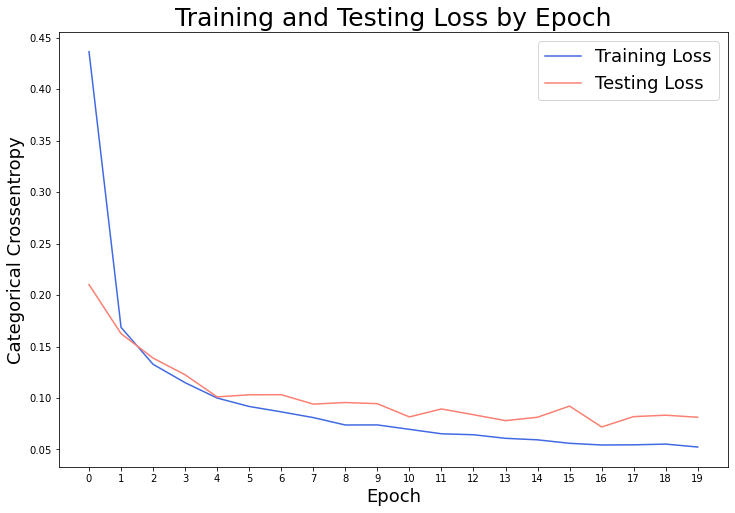

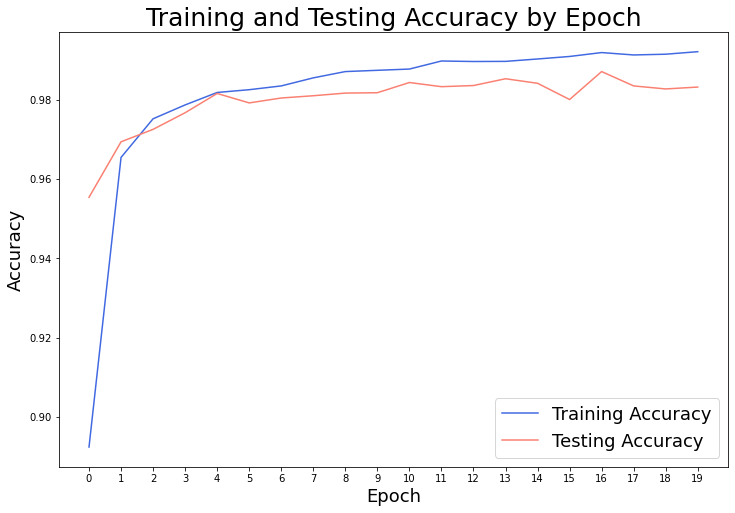

In [49]:
# Training and testing loss
loss_graph(history2)

# Training and testing accuracy
accuracy_graph(history2)

### Kaggle testing data

In [53]:
sample_kaggle = pd.read_csv('sample_submission.csv')
sample_kaggle

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [54]:
kaggle_data = pd.read_csv('test.csv')
kaggle_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X_test.shape

(10500, 28, 28, 1)

In [62]:
kaggle_data_numpy = kaggle_data.to_numpy()
kaggle_data_numpy[:5,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [64]:
kaggle_data_numpy = kaggle_data_numpy.astype('float32')
kaggle_data_numpy /= 255.0
kaggle_data_numpy = kaggle_data_numpy.reshape(kaggle_data_numpy.shape[0], 28, 28, 1)

In [66]:
y_preds = model2.predict(kaggle_data_numpy)

875/875 [==============================] - 2s 3ms/step


In [68]:
y_preds.shape

(28000, 10)

In [71]:
label = np.argmax(y_preds, axis=1)
label.shape

(28000,)

In [72]:
sample_kaggle['Label'] = label
sample_kaggle

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [73]:
# sample_kaggle.to_csv('submission.csv')